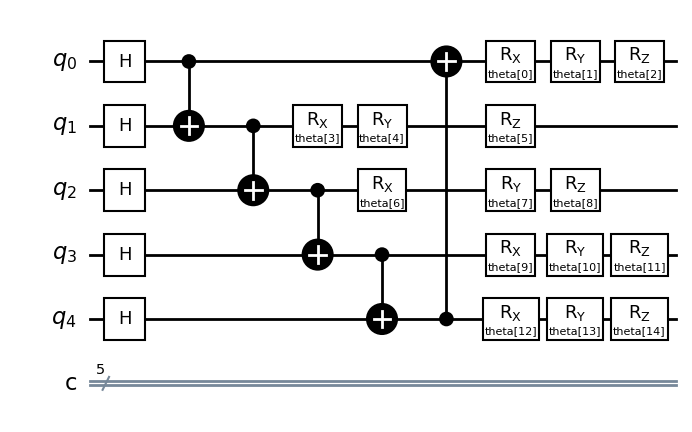

/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_47418/270770482.py:22: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


[array([ 7.28583860e-17,  3.26414752e-01, -1.73472348e-17,  1.28369537e-16,
        -3.72111379e-02, -1.00613962e-16,  2.77555756e-17,  1.31360208e-02,
         1.49186219e-16,  1.07552856e-16, -8.46223775e-02, -6.24500451e-17,
         0.00000000e+00, -9.79862095e-03,  0.00000000e+00])]

In [33]:

def psr_qiskit(num_qubits: int):
    import qiskit
    from qiskit.quantum_info import SparsePauliOp
    from qiskit.primitives import Estimator
    from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
    import numpy as np
    thetas = qiskit.circuit.ParameterVector('theta', num_qubits * 3)
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    for j in range(num_qubits):
        qc.h(j)
    for j in range(num_qubits):
        qc.cx(j, (j + 1) % num_qubits)
    k = 0
    for j in range(num_qubits):
        qc.rx(thetas[k], j)
        qc.ry(thetas[k + 1], j)
        qc.rz(thetas[k + 2], j)
        k += 3
    display(qc.draw('mpl', style = 'bw'))
    H = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
    params = [np.random.uniform(0, 2*np.pi, 3*num_qubits)]
    estimator = Estimator()
    grad = ParamShiftEstimatorGradient(estimator).run(qc, H, params).result().gradients
    return grad
psr_qiskit(5)

In [18]:
def psr_pennylane(num_qubits: int):
    import pennylane as qml
    from pennylane import numpy as pnp
    import numpy as np
    dev = qml.device("default.qubit")
    @qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
    def circuit(params, num_qubits):
        for j in range(num_qubits):
            qml.Hadamard(wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])
        k = 0
        for j in range(num_qubits):
            qml.RX(params[k], wires=j)
            qml.RY(params[k+1], wires=j)
            qml.RZ(params[k+2], wires=j)
            k += 3
        H = qml.PauliZ(0)
        for j in range(1, num_qubits):
            H = H @ qml.PauliZ(j)
        return qml.expval(H)
    params = pnp.array(np.random.uniform(0, 2*np.pi, 3*num_qubits), requires_grad=True)
    grad = qml.jacobian(circuit)(params, num_qubits)
    return grad
psr_pennylane(num_qubits = 15)

array([-6.54586357e-18,  4.14582351e-06,  8.07053697e-18,  2.00645235e-17,
        1.67697208e-04,  4.93990319e-18,  1.00153246e-17, -1.17443964e-05,
        1.13570248e-17,  4.01155508e-18,  7.28150046e-06,  1.78216437e-18,
       -1.42978457e-18, -2.06952806e-05, -7.23026619e-18,  8.14507587e-18,
       -1.24848392e-06, -6.37645698e-18,  9.20217298e-18, -3.43855530e-05,
       -4.46555065e-18,  9.00566134e-18, -3.09317672e-07,  1.26716833e-18,
        1.72862554e-17, -1.99161576e-05, -2.47332916e-18,  1.91768964e-18,
       -8.38635424e-06, -3.59818891e-18,  9.71716902e-18,  1.18371290e-05,
       -8.06368320e-19, -3.59134924e-19,  3.16350369e-05,  1.18178107e-17,
        4.54010364e-18, -7.81075155e-06, -1.19262169e-17, -8.40249638e-19,
       -2.13760507e-04,  1.05642020e-17,  7.06087369e-18,  1.77930926e-04,
        3.38883634e-20])

In [17]:
def psr_qulacs(num_qubits: int):    
    from qulacs import ParametricQuantumCircuit, GradCalculator, Observable
    import numpy as np
    observable = Observable(num_qubits)
    observable_str = " ".join([f"Z {i}" for i in range(num_qubits)])
    observable.add_operator(1.0, observable_str)
    circuit = ParametricQuantumCircuit(num_qubits)

    theta = np.random.uniform(0, 2*np.pi, 3*num_qubits)
    for j in range(num_qubits):
        circuit.add_H_gate(j)
    for j in range(num_qubits):
        circuit.add_CNOT_gate(j, (j + 1) % num_qubits)
    k = 0
    for j in range(num_qubits):
        circuit.add_parametric_RX_gate(j, theta[k])
        circuit.add_parametric_RY_gate(j, theta[k + 1])
        circuit.add_parametric_RZ_gate(j, theta[k + 2])
        k += 3
    gcalc = GradCalculator()
    print(np.real(gcalc.calculate_grad(circuit, observable, theta)))
psr_qulacs(15)

[-1.62630326e-17  1.31569850e-03  0.00000000e+00  0.00000000e+00
  2.10764938e-03  0.00000000e+00  4.22838847e-18 -4.58006751e-04
 -7.26415456e-18 -7.91467586e-18 -2.06826252e-04 -8.89045781e-18
 -1.02999206e-17  2.77539621e-03  3.57786717e-18 -9.10729825e-18
  2.90417075e-03  3.41523684e-17 -6.07153217e-18 -2.86914568e-04
 -5.20417043e-18  2.85145171e-17 -6.94077805e-04 -1.43114687e-17
  1.38777878e-17 -9.87972784e-05 -1.78893358e-17 -1.97324795e-17
  6.95438342e-05 -3.25260652e-19 -7.80625564e-18 -2.45242328e-04
  3.20923843e-17  0.00000000e+00  4.06839552e-04 -1.59377719e-17
  1.92987987e-17  1.13294540e-03 -7.48099499e-18 -2.63461128e-17
  1.59661279e-04 -1.73472348e-17 -2.16840434e-19 -1.18183781e-02
  1.84314369e-18]


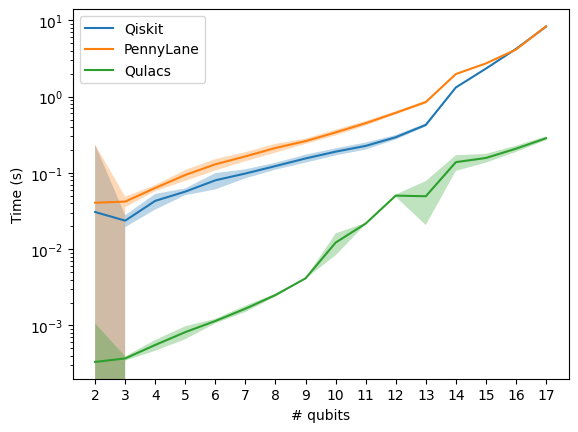

In [27]:
import numpy as np

times_qiskit = np.loadtxt('./times/qiskit.txt')
times_pennylane = np.loadtxt('./times/pennylane.txt')
times_qulacs = np.loadtxt('./times/qulacs.txt')
times_qiskit_std = np.loadtxt('./times/qiskit_std.txt')
times_pennylane_std = np.loadtxt('./times/pennylane_std.txt')
times_qulacs_std = np.loadtxt('./times/qulacs_std.txt')
import matplotlib.pyplot as plt

qubits = range(2,18)
plt.fill_between(qubits, times_qiskit - times_qiskit_std, times_qiskit + times_qiskit_std, alpha=0.3)
plt.fill_between(qubits, times_pennylane - times_pennylane_std, times_pennylane + times_pennylane_std, alpha=0.3)
plt.fill_between(qubits, times_qulacs - times_qulacs_std, times_qulacs + times_qulacs_std, alpha=0.3)
plt.plot(qubits, times_qiskit, label='Qiskit')
plt.plot(qubits, times_pennylane, label='PennyLane')
plt.plot(qubits, times_qulacs, label='Qulacs')
plt.xlabel('# qubits')
plt.xticks(qubits)
plt.ylabel('Time (s)')
plt.yscale('log')
plt.legend()
